In [9]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
#https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
import pandas as pd
import numpy as np
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

In [11]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=536.818, BIC=556.362, Fit time=0.914 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=626.061, BIC=635.834, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=598.004, BIC=614.292, Fit time=0.356 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=613.475, BIC=629.762, Fit time=0.294 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=559.502, BIC=582.305, Fit time=1.581 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=561.407, BIC=577.695, Fit time=0.218 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=538.817, BIC=561.620, Fit time=2.526 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=531.829, BIC=554.632, Fit time=0.857 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1, 12);

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(0, 1, 1, 12)   Log Likelihood                -258.300
Date:                            Thu, 27 Jun 2019   AIC                            530.601
Time:                                    14:23:40   BIC                            553.403
Sample:                                         0   HQIC                           539.836
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1649      0.097      1.705      0.088      -0.025       0.354
x1          3.934e-07   2.55e-09    153.998      0.000    3.88e-07    3.98e-07
ar.L1          0.0949      0.043      2.205      0.027       0.011       0.179
ar.L2          0.4145      0.035     11.907      0.000       0.346       0.483
ar.L3          0.3531      0.053      6.601      0.000       0.248       0.458
ma.S.L12      -0.4635      0.058     -8.008      0.000      -0.577      -0.350
sigma2         0.8461      0.057     14.925      0.000       0.735       0.957
===================================================================================
Ljung-Box (Q):                       59.80   Jarque-Bera (JB):               124.59
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.75   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.09e+16. Standard errors may be unstable.
"""

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


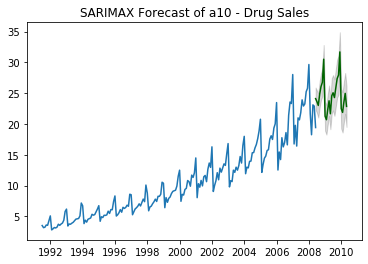

In [14]:
# Forecast
#forecasting
import matplotlib.pylab as plt
%matplotlib inline
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

In [15]:
len(np.tile(seasonal_index.value,2))

24

In [16]:
seasonal_index

,value,month
date,,
2007-07-01,0.970490,7
2007-08-01,1.050900,8
2007-09-01,0.998881,9
2007-10-01,1.059657,10
2007-11-01,1.146141,11
2007-12-01,1.150750,12
2008-01-01,1.316913,1
2008-02-01,0.803279,2
2008-03-01,0.850667,3


In [17]:
len(data)

204

In [18]:
fitted

array([24.12770669, 23.63988566, 23.01797636, 24.85549457, 26.07876238,
       26.78156721, 30.52620927, 21.27634116, 20.70198956, 22.29718153,
       23.77668763, 21.67211067, 24.57727491, 25.08118197, 24.2970755 ,
       25.89793657, 27.38168141, 27.95385132, 31.71049484, 22.49959194,
       21.88778758, 23.49981237, 24.97915102, 22.86831088])

In [19]:
confint

array([[22.32487349, 25.9305399 ],
       [21.82894614, 25.45082518],
       [21.05266413, 24.9832886 ],
       [22.74105552, 26.96993363],
       [23.91676935, 28.24075542],
       [24.52804977, 29.03508464],
       [28.21286957, 32.83954897],
       [18.91527036, 23.63741195],
       [18.29142704, 23.11255208],
       [19.84918312, 24.74517993],
       [21.29480687, 26.25856838],
       [19.16021344, 24.1840079 ],
       [21.73779984, 27.41674999],
       [22.20926007, 27.95310387],
       [21.33472114, 27.25942987],
       [22.85054195, 28.94533118],
       [24.29008012, 30.47328269],
       [24.80413618, 31.10356646],
       [28.51723838, 34.9037513 ],
       [19.26994407, 25.72923981],
       [18.62319529, 25.15237986],
       [20.20686839, 26.79275634],
       [21.66089195, 28.29741009],
       [19.52770313, 26.20891863]])

In [21]:
fitted_series

2008-06-01    24.127707
2008-07-01    23.639886
2008-08-01    23.017976
2008-09-01    24.855495
2008-10-01    26.078762
2008-11-01    26.781567
2008-12-01    30.526209
2009-01-01    21.276341
2009-02-01    20.701990
2009-03-01    22.297182
2009-04-01    23.776688
2009-05-01    21.672111
2009-06-01    24.577275
2009-07-01    25.081182
2009-08-01    24.297076
2009-09-01    25.897937
2009-10-01    27.381681
2009-11-01    27.953851
2009-12-01    31.710495
2010-01-01    22.499592
2010-02-01    21.887788
2010-03-01    23.499812
2010-04-01    24.979151
2010-05-01    22.868311
Freq: MS, dtype: float64

In [22]:
data['value']

date
1991-07-01     3.526591
1991-08-01     3.180891
1991-09-01     3.252221
1991-10-01     3.611003
1991-11-01     3.565869
1991-12-01     4.306371
1992-01-01     5.088335
1992-02-01     2.814520
1992-03-01     2.985811
1992-04-01     3.204780
1992-05-01     3.127578
1992-06-01     3.270523
1992-07-01     3.737851
1992-08-01     3.558776
1992-09-01     3.777202
1992-10-01     3.924490
1992-11-01     4.386531
1992-12-01     5.810549
1993-01-01     6.192068
1993-02-01     3.450857
1993-03-01     3.772307
1993-04-01     3.734303
1993-05-01     3.905399
1993-06-01     4.049687
1993-07-01     4.315566
1993-08-01     4.562185
1993-09-01     4.608662
1993-10-01     4.667851
1993-11-01     5.093841
1993-12-01     7.179962
                ...    
2006-01-01    23.486694
2006-02-01    12.536987
2006-03-01    15.467018
2006-04-01    14.233539
2006-05-01    17.783058
2006-06-01    16.291602
2006-07-01    16.980282
2006-08-01    18.612189
2006-09-01    16.623343
2006-10-01    21.430241
2006-11-01 